In [30]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import hvplot as hv
import hvplot.pandas
import sys, os
import pickle
import matplotlib.pyplot as plt
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # parent of notebooks
if project_root not in sys.path:
    sys.path.append(project_root)
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score,balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, root_mean_squared_error, mean_absolute_error, mean_squared_error

from src.util.model import eval_model, prep_data
seed = 42

In [2]:
# dff0 = pd.DataFrame()

# data_fp = "../../data/training_data"
# training_data = os.listdir(data_fp)
# for i in range(len(training_data)):
#     # if i > 4: 
#     #     break
#     fn = training_data[i]
#     df = pd.read_csv(os.path.join(data_fp, fn))
#     print(f"{fn} {df.shape}")
#     dff0 = pd.concat([dff0, df])
# print(dff0.shape)

dff0 = pd.read_csv("../../data/training_combined/training_combined.csv")

danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])

coords_geodf = gpd.read_file("../../../data/FAC/zones/grid_coords_subset.geojson")

In [3]:
exclude_cols = ['date','id_x','slope_azi', 'danger_level','altitude','slope_angle','elevation_band','lat', 'lon', 'zone_name', 'geometry']
# X, y, excluded_cols = prep_data(
#     dff0, 
#     danger_levels, 
#     coords_geodf,
#     replace_missing=True, 
#     change_danger=True,
#     exclude_cols=['date','id','id_x','slope_azi', 'danger_level','altitude','slope_angle','forecast_zone_id','elevation_band','lat', 'lon', 'zone_name', 'geometry']) 

X = dff0.loc[:, ~dff0.columns.isin(exclude_cols)].copy(deep=True)
y = dff0['danger_level']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [5]:
# Params found from tuning
# {'class_weight': 'balanced', 
#  'max_depth': 50, 
#  'max_features': 0.5, 
#  'min_samples_leaf': 4, 
#  'min_samples_split': 20, 
#  'n_estimators': 1000}


rf = RandomForestClassifier(random_state=seed, n_jobs=-1,
                            max_depth=50,
                            max_features=0.5,
                            min_samples_leaf=4,
                            min_samples_split=20,
                            n_estimators=500,
                            class_weight='balanced'
                           )

# with open("../../data/models/best_model.pkl", "rb") as file:
#     rf = pickle.load(file)

In [24]:
cv = cross_val_score(rf, X_train,y_train,cv=5,n_jobs=-1)

In [29]:
print(f"CV Results: Mean Accuracy - {cv.mean():.2f}% std - {cv.std():.2f}")

CV Results: Mean Accuracy - 0.74% std - 0.01


In [6]:
rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,50
,min_samples_split,20
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Train
Accuracy 0.95
Balanced Accuracy 0.96
MAE: 0.06315518682873497
Test
Accuracy 0.75
Balanced Accuracy 0.79
MAE: 0.26586646661665414


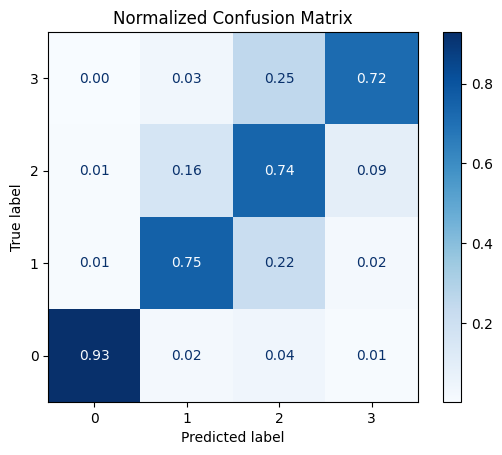

In [7]:
y_pred = rf.predict(X_test)

print("Train")
eval_model(y_train, rf.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)

In [8]:
test_data = pd.concat([X_test,dff0[exclude_cols].iloc[X_test.index]],axis=1)
test_data['predicted'] = y_pred
test_data.head()

,Qs,Ql,Qg,TSG,Qg0,Qr,dIntEnergySnow,meltFreezeEnergySnow,ColdContentSnow,OLWR,...,slope_azi,danger_level,altitude,slope_angle,elevation_band,lat,lon,zone_name,geometry,predicted
16830,11.821742,-9.545492,0.0,-3.090242,-4.935358,0.001508,-33.501192,-4.086192,-0.562033,288.793975,...,108.0,3,1604.9,30.4,middle,48.549201,-114.361584,whitefish,POINT (-114.36158376686912 48.549201338800984),3
7752,6.378950,-22.336517,0.0,-5.740725,-0.939392,0.000000,17.358983,1.231875,-1.227058,267.441408,...,108.0,1,1480.4,30.4,lower,48.414122,-113.917176,flathead,POINT (-113.91717577052131 48.41412177241847),1
15019,-1.258875,-15.595433,0.0,-5.279708,0.903767,0.000000,9.580300,-12.989925,-3.086358,282.191400,...,108.0,2,1948.0,30.4,middle,48.594342,-113.762443,flathead,POINT (-113.76244341532244 48.59434223968469),2
247,8.823875,-13.504025,0.0,-4.597542,-1.778258,0.000000,-2.713217,1.507325,-1.535908,278.727275,...,108.0,1,1757.7,30.4,middle,48.243116,-113.992494,swan,POINT (-113.99249394059275 48.24311604465016),2
3588,16.530917,-2.632192,0.0,-2.905958,4.211600,0.000000,21.392650,0.426675,-0.928000,286.507017,...,108.0,2,1737.3,30.4,middle,48.290655,-114.046015,swan,POINT (-114.04601483899994 48.29065539193382),2


In [20]:
feature_importances = pd.DataFrame(rf.feature_importances_,index = rf.feature_names_in_, columns=["importance"]).sort_values(by="importance", ascending=False)
print(feature_importances[feature_importances['importance'] > 0].index)

Index(['mAlbedo', 'ISWR_diff', 'TA', 'HS_mod', 'HN72_24', 'wind_trans24',
       'SWE', 'MS_Water', 'RH', 'ISWR_h', 'HS_meas', 'dIntEnergySnow',
       'ColdContentSnow', 'pAlbedo', 'S5', 'ISWR_dir', 'MS_Sublimation',
       'OLWR', 'ski_pen', 'ISWR', 'zS4', 'zSn', 'zSs', 'DW', 'TSS_mod',
       'Sclass2', 'ILWR', 'VW', 'VW_drift', 'PSUM24', 'MS_Snow', 'Qg0', 'HN24',
       'Qw', 'LWR_net', 'Ql', 'Qs', 'meltFreezeEnergySnow', 'S4', 'Sn', 'OSWR',
       'HN6', 'zSd', 'HN3', 'HN12', 'Ss', 'Sd', 'T_bottom', 'TSG', 'MS_Evap',
       'MS_Surface_Mass_Flux', 'MS_SN_Runoff', 'MS_Wind', 'MS_Rain', 'Qr',
       'hoar_size'],
      dtype='object')


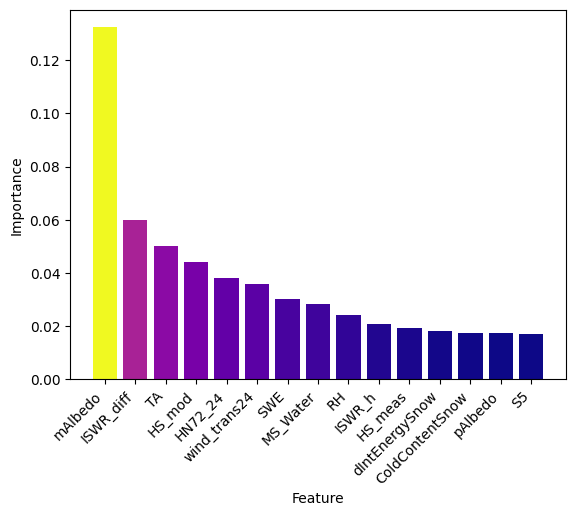

In [21]:
top = feature_importances.iloc[:15]
 
# Normalize and create colors
norm = plt.Normalize(top['importance'].min(), top['importance'].max())
cmap = plt.cm.plasma
colors = cmap(norm(top['importance']))

# Create figure and axes
fig, ax = plt.subplots()

bars = ax.bar(top.index, top['importance'], color=colors)

# Add colorbar — note the ax parameter
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Required for colorbar
# fig.colorbar(sm, ax=ax, label='Importance')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [ ]:

# with open("../../data/models/best_model.pkl", "ab") as file:
#     pickle.dump(rf, file)
    
with open("../../data/models/best_model.pkl", "rb") as file:
    best_model = pickle.load(file)
    
y_pred = best_model.predict(X_test)

print("Train")
eval_model(y_train, best_model.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)